# Action Balance Equation Fenics Convergence Test Notebook for Stabilized FEM

This notebook provides several numerical test cases where the convergence rates of the error in numerical solutions are tested with respect to analytic solutions. The governing equation for spectral wind wave models, the action balance equation, is considered. In all these cases, only methods that are FEM in space and finite difference in time are considered. Maybe full space-time FEM can be added later, but computational cost is prohibitive


## $\frac{\partial N}{\partial t} + \nabla \cdot \mathbf{c} N  = \frac{S(\mathbf{x}, t)}{\sigma}$


## Test 1: Propogation Test Case:

Goal: Evaluate capabilities of different FEM schemes in "pure advection" scenario
by setting source to $S$ to 0.


Setup: Harmonic wave propogating across 2D domain, c is constant in x and y:

$\frac{\partial N}{\partial t} +  \textbf{c} \cdot \nabla N = 0$

$\Omega = [0,10] \times [0,10]$

$\textbf{c} = (1 , 1)$

$N_0 = sin(x) + cos ( y)$

$N_{analytic} = sin(x - c_xt) + cos(y - c_yt)$

$N = N_{analytic}$  on $\partial \Omega$

Total time = 5

number of time steps = 1000

(time step set small so really just focusing on FEM error convergence part on this test)

## Test 2: Propogation with growth added

Goal: Similar to Test 1 but now considering growth term. Qualitatively looks kind of like a spectrum maturing. Inspired from test case from:

H. Egger, J. Schoberl, A hybrid mixed discontinuous Galerkin finite-element method for convection–diffusion241
problems, IMA Journal of Numerical Analysis 30 (4) (2010) 1206–1234.


Domain:

$\Omega = (0, L) \times (0,L)$

$L=1$

Assume:

$\textbf{c} = \{1,0\}$

$u_{exact} =  (-4(y-0.5)^2+1)\left[ x + \frac{e^{\gamma \cdot b_x \cdot x} - 1 }{1 - e^{\gamma \cdot b_x}}\right]$ 

$\gamma = 100t$

$t=[0.01,1]$

number of time steps = 1000

Which makes action balance equation:

$\frac{\partial N}{\partial t} + \frac{\partial N}{\partial x}   = S(x, y, t)$

From analytic differentiation S should be:

$(-4(y-0.5)^2+1)\left[\frac{100 e^{100t}(e^{100tx} - 1)}{(1-e^{100t})^2} + \frac{100xe^{100tx}}{1-e^{100t}}\right] + (-4(y-0.5)^2+1)\left[ 1 + \frac{100t e^{\gamma \cdot b_x \cdot x} }{1 - e^{\gamma \cdot b_x}}\right]$


## Test 3: Adding non-uniform velocity field

(may still need some more work)

Domain:

$\Omega = (0, L) \times (0,L)$

$L=1$

Assume:
(trying to be like dispersion relation ($c_g = c_p = \sqrt{gh}$)

$\textbf{c} = \{ \sqrt{1+x},\sqrt{1+x}\}$

$u=e^{t}\sin(c_1\pi x)\sin(c_2\pi y)$ 



Which makes action balance equation:

$\frac{\partial N}{\partial t} + \frac{\partial N}{\partial x} + \frac{\partial N}{\partial y}  = S(x, y, t)$


## Test 4: Uniform coastline:

Assuming coast line that varies along x direction but is uniform in y, mathematically meaning:

$\frac{\partial N}{\partial y} = 0$ and $\frac{\partial c_{y}}{\partial y} = 0$

Which makes action balance equation:

$\frac{\partial N}{\partial t} + \frac{\partial c_x N}{\partial x} + \frac{\partial c_\sigma N}{\partial \sigma}+ \frac{\partial c_\theta N}{\partial \theta}  = \frac{S(\sigma, \theta, t)}{\sigma}$

In this specific script we will perform the test as seen in ONR test bed case A21

## Case A21

"An infinitely long plane beach with parallel depth contours (slope 1:200) is considered. The x-axis is normal to the depth contours (see Figure 7). At a water depth of 20m, monochromatic, uni- directional waves enter the model area. At the up-wave boundary the incoming waves propagate at an angle of 0° relative to the positive x-axis. The distance of the up-wave boundary to the waterline is 4000 m. The incident wave height Hi and period Ti are 1 m and 10 s respectively.
Ambient currents and wind are absent."

## Conditions
In the SWAN computation this harmonic wave is simulated with a Gaussian-shaped frequency spectrum with peak
frequency 0.1 Hz, standard deviation 0.01 Hz, and a resolution
of 3% of the frequency (diffusion in frequency space does not
occur as $c_{\sigma}$= 0 in this case, and the frequency resolution may
therefore be somewhat coarse). The long crestedness in this
computation is simulated with a $cos^{500} (\theta)$ directional distribution (the directional width $\sigma_{\theta} = 2.5 $ degrees, where su is the standard
deviation of the directional distribution



## Solution

$\frac{H^2}{H_i^2}=\frac{c_{g,i}cos(\theta_i)}{c_g cos(\theta)}$

Where $H_i$ , $c_{g,i}$, $\theta_i$ is the boundary condition that remains steady through time


## Weak Forms:

### Discontinuous Galerkin

### Least Squares

### SUPG

### Galerkin

### SUPG with DG elements


In [1]:
#import any necessary libraries in this block
from __future__ import print_function
from fenics import *
from ufl import nabla_div
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#define global variables
g=9.81

In [3]:
#all functions necessary to run Test Case 4
#this expression requires sigma to be in second index
def Gauss_Expression_1D(F_peak,F_std,HS):
    aux1 = aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    #CTOT = np.sqrt(0.5*500/np.pi)/(1-0.25/500)
    E=Expression('aux1*exp(-pow(x[1]-2*pi*F_peak,2)/aux3)',
                degree=4,aux1=aux1,aux3=aux3,F_peak=F_peak)
    return E

def Gauss_Expression_IC(F_peak,F_std,HS):
    aux1 = aux1 = HS**2/(16*np.sqrt(2*np.pi)*F_std)
    aux3 = 2*F_std**2
    tol=1e-14
    #CTOT = np.sqrt(0.5*500/np.pi)/(1-0.25/500)
    E=Expression('x[0] < tol ? aux1*exp(-pow(x[1]-2*pi*F_peak,2)/aux3): 0',
                degree=4,aux1=aux1,aux3=aux3,F_peak=F_peak,tol=tol,t=0)
    return E
#an Expression class to evaluate u(x,y) on the 1D domain (range y, x fixed)
#maybe modify so input can determine if we want range y (fixed x) or range x (fixed y)
#this case want space to be x, sigma to be y
class my1DExpression(UserExpression):
    def __init__(self,u_2d,x,**kwargs):
        super().__init__(**kwargs)
        self.u_2d=u_2d
        self.x=x
        #Expression.__init__(self)
        self._vx= np.array([0.])
        self._pt_x= np.array([0.,0.])
    def eval(self, values, x):
        self._pt_x[0]= self.x
        self._pt_x[1]= x[0]
        self.u_2d.eval(self._vx,self._pt_x)
        values[0] = self._vx[0]
        
#need a function to calculate wave speed (phase and group) and wavenumber
def swan_calc_wavespeeds_k(sigmas,depths,g=9.81):
    #taken from Jessica's code
    cg_out=np.zeros(len(sigmas))
    k_out=np.zeros(len(sigmas))
    WGD=np.sqrt(depths/g)*g
    SND=sigmas*np.sqrt(depths/g)
    
    shallow_range=np.argwhere(SND<1e-6)
    mid_range=np.argwhere((SND<2.5)&(SND>=1e-6))
    deep_range=np.argwhere(SND>=2.5)
    
    def cg_mid(SND,g,depths,sigmas):
        SND2=SND*SND
        C=np.sqrt(g*depths/(SND2 +1/(1+0.666*SND2+.445*SND2**2 
                                     - 0.105*SND2**3 + 0.272*SND2**4)))
        KND=sigmas*depths/C
        
        FAC1=2*KND/np.sinh(2*KND)
        N=0.5*(1+FAC1)
        return N*C,sigmas/C
    def cg_deep(g,sigmas):
        return 0.5*g/sigmas
    def cg_shallow(WGD):
        return WGD

    cg_out[shallow_range]=cg_shallow(WGD[shallow_range])
    k_out[shallow_range]=SND[shallow_range]/depths[shallow_range]
    cg_out[mid_range],k_out[mid_range]=cg_mid(SND[mid_range],g,depths[mid_range],sigmas[mid_range])
    cg_out[deep_range]=cg_deep(g,sigmas[deep_range])
    k_out[deep_range]=sigmas[deep_range]**2/g

    return cg_out,k_out

def calc_c_sigma(sigmas,k,depths,c_g,currents,z_coords,loc_num):
    ##Inputs
    #sigmas - takes in a vector of sigma values (sigma coordinate at each d.o.f) at one point in physical spaxe
    #thetas
    #k - wavenumber corresponding to the given sigmas and thetas
    #c_g - corresponding group velocity
    #(note sigmas, thetas,k,c_g should all be same length which is number of d.o.f in one 2D slice)
    #depths - depths in meters of ALL physical coordinates (not just current one)
    #z_coords - unique coordinates in physical space (not just current one)
    #currents - water velocity at ALL physical coordinates
    #loc_num - the number of the physical point (starts at 0)
    #(note depths,z_coords,currents should all be same length which is the number of unique points in physical space)
    ##Outputs
    #outputs a vector same size as sigmas that is the c_sigma at all d.o.f in ONE 2D slice 
    #of the 3D domain corresponding to a single point in physical space for c_theta and c_sigma
    
    #for now assuming H is constant in time but can fix this later
    dHdt=0.0
    dHdy = 0.0
    dudy = 0.0
    dvdx = 0.0 #migh not have to be 0, well see
    dvdy = 0.0
    
    #also going to assume v is zero but maybe can change this later
    v=0.0
    u=0.0#currents[loc_num]
    H=depths#[loc_num]
    #calc gradient of H w.r.t. x
    #this is just forward euler but only works for fixed geometry
    #instead we'll hard code for this case
    dHdx=-1.0/200.0
    dudx=0.0
    '''
    if loc_num == 0:
        dHdx =(depths[loc_num+1]-H)/(z_coords[loc_num+1]-z_coords[loc_num])
        dudx = (currents[loc_num+1]-u)/(z_coords[loc_num+1]-z_coords[loc_num])
    elif loc_num == len(z_coords)-1:
        dHdx = (H-depths[loc_num-1])/(z_coords[loc_num]-z_coords[loc_num-1])
        dudx = (u-currents[loc_num-1])/(z_coords[loc_num]-z_coords[loc_num-1])
    else:
        dHdx = (depths[loc_num+1]-depths[loc_num-1])/(z_coords[loc_num+1]-z_coords[loc_num-1])
        dudx = (currents[loc_num+1]-currents[loc_num-1])/(z_coords[loc_num+1]-z_coords[loc_num-1])
    '''
    
    #now calculate velocity vectors
    c_sigma = k*sigmas/(np.sinh(2*k*H)) *(dHdt + u*dHdx + v*dHdy) - c_g*k*(dudx)
    #c_theta = sigmas/(np.sinh(2*k*H))*(dHdx*np.sin(thetas)- dHdy*np.cos(thetas)) + \
    #    dudx*np.cos(thetas)*np.sin(thetas) - dudy*(np.cos(thetas)**2) + dvdx*(np.sin(thetas)**2) \
    #    -dvdy*np.cos(thetas)*np.sin(thetas)
    return c_sigma #,c_theta


#function that generates the weak form
def gen_weakform(mesh,WeakForm,V,u_n,c,dt,S_express,u_D,p_degree=4,TimeStep='Implicit_Euler'):
    #Inputs:
    #mesh is the domain
    #WeakForm is string representing the variational formulation
    #V is solution space that should be chosen
    #u_D are dirichlet boundary conditions as an expression
    #p_degree is the degree expressions will be approximated to
    #wave speed c should be a function
    
    #Outputs:
    #entire weak form as F
    #boundary condition as bc
    #initial condition as u_n (necessary for time stepping)
    
    #Define source term, boundary, and wave propogation depending on test case choice
    u = TrialFunction(V)
    v = TestFunction(V)

    S=interpolate(S_express,V)

    #if WeakForm == 'Galerkin':
        #bc = DirichletBC(V, u_n, boundary,"geometric")
    #else:
        #bc = DirichletBC(V, u_n, boundary)
  
    
    

    if WeakForm == 'LSQ':
        #Least Squares bilinear form
        #(Au, Av) = (f, Av) <==> (Au-f,Av) = 0
    
        if TimeStep == 'Implicit_Euler':
            #Implicit Euler
            n=FacetNormal(mesh)
            dof_coordinates=V.tabulate_dof_coordinates()
            n_dof=V.dim()
            d=mesh.geometry().dim()
            dof_coordinates.resize((n_dof,d))
            x = dof_coordinates[:,0]
            X_right = max(x)
            x, y = SpatialCoordinate(mesh)
            Gamma_right = conditional(x > X_right-1e-14, 1,0)
            F=(inner(u + dt*nabla_div(c*u) - u_n - dt*S, v + dt*nabla_div(c*v) ))*dx
        elif TimeStep == 'Trap_Rule':
            #Trap Rule
            F = (inner(u + 0.5*dt*nabla_div(c*u) + 0.5*dt*nabla_div(c*u_n) - u_n -dt*S, v + 0.5*dt*nabla_div(c*v) ))*dx
        elif TimeStep == 'Explicit_Euler':
            #Explicit Euler
            F = (inner(u+dt*nabla_div(c*u_n) - u_n - dt*S, v))*dx

    elif WeakForm == 'DG':
        #continuous galerkin bilinearr form
        if TimeStep == 'Implicit_Euler':
            n=FacetNormal(mesh)
            cn=(dot(c,n) + abs(dot(c,n)))/2
            cn2 = (-dot(c,n) + abs(dot(c,n)))/2
            F = inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx + dt*inner( cn('+')*u('+') - cn('-')*u('-'), jump(v) )*dS + dt*inner( u*dot(c,n), v )*ds
            #F = inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx + dt*inner( cn('+')*u('+') - cn('-')*u('-'), jump(v) )*dS \
            #    + dt*u*cn*v*ds - dt*u_D*cn2*v*ds #+ dt*inner( u*dot(c,n), v )*ds#
    elif WeakForm == 'SUPG':
        if TimeStep == 'Implicit_Euler':
            hmax=mesh.hmax()
            #h=Constant(5)
            #tau=Expression('pow(sqrt(yn*yn+ym*ym+yz*yz)/hh,-1)', degree=p_degree ,  domain=mesh, yn=1 , ym=1,yz=1 , hh=hmax)
            #tau=Expression('0',degree=1)
            tau=hmax/dot(c,c)**0.5
            n=FacetNormal(mesh)
            F = inner(u - dt*S -u_n,v)*dx - dt*(inner(c*u,grad(v)))*dx + dt*inner(u*dot(c,n), v)*ds \
            + inner((u- u_n) + dt*nabla_div(c*u) - dt*S , tau*nabla_div(c*v))*dx
    elif WeakForm == 'Galerkin':
        if TimeStep == 'Implicit_Euler':
            n=FacetNormal(mesh)
            F = inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx + dt*inner(u*dot(c,n), v)*ds
            
    elif WeakForm == 'SUPGDG':
        if TimeStep == 'Implicit_Euler':
            n=FacetNormal(mesh)
            cn=(dot(c,n) + abs(dot(c,n)))/2
            cn2 = (-dot(c,n) + abs(dot(c,n)))/2
            hmax=mesh.hmax()
            tau=hmax/(dot(c,c)**0.5)
            F = inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx  \
                + dt*inner( cn('+')*u('+') - cn('-')*u('-'), jump(v) )*dS + dt*u*cn*v*ds - dt*u_D*cn2*v*ds \
                + inner((u- u_n) + dt*nabla_div(c*u) - dt*S , tau*nabla_div(c*v))*dx
            
    return F,S

def run_forward_model(F,num_steps,dt,u_D,bc,u_n,V,S_express,S,return_errors=True,t_i=0):
    #all problems are linear so split into lhs,rhs
    a,L = lhs(F), rhs(F)
    # establishes solution variable (possible output)
    u = Function(V)
    #initialize time at 0
    t=t_i
    #for now l2 and l-infinity errors are computed at each time step
    l2_err_vec=np.zeros(num_steps)
    l_inf_error_vec = np.zeros(num_steps)
    
    #now loop in time
    for n in range(num_steps):
        #advance time
        t+=dt
        #update dirichlet boundary and source term
        u_D.t = t
        S_express.t = t
        S_func=interpolate(S_express,V)
        S.assign(S_func)
        #compute solution at new timestep
        solve(a == L, u,bc)
        #update solution
        u_n.assign(u)
        if return_errors:
            # Compute exact solution at vertices(assumes u_D is expression for whole space)
            u_e = interpolate(u_D, V)
            #L2 error
            e0=u-u_e
            l2_err_vec[n] = np.sqrt(assemble(inner(e0,e0)*dx))
            #l infinity error
            u_vec=u.compute_vertex_values()
            u_exac_vec=u_e.compute_vertex_values()
            #L infinity error
            l_inf_error_vec[n] = np.abs(u_exac_vec-u_vec).max()
    #if computed, return errors at each time step, always returns final solution
    if return_errors:
        return l_inf_error_vec,l2_err_vec,u
    else:
        return u
#parses inputs and runs simulation
def run_sim(test_case_no,weak_form,p_type,pq_degree,nx):
    
    if test_case_no == 1:
        #specify parameters related to test 1
        T = 5 # final time step
        T_i=0
        num_steps = 1000 # number of time steps
        dt = T / num_steps  # time step size
        L = 10 #length of domain
        #create mesh
        mesh = RectangleMesh(Point(0.0,0.0),Point(L,L),nx[0], nx[0])
        #create function space on mesh
        V=FunctionSpace(mesh,p_type[0],pq_degree[0])
        c_sigma = 1.0         # define propogation speeds
        c_theta = 1.0
        c = Constant((c_sigma,c_theta))
        #define boundary condition(exact solution as well in this case)
        u_D = Expression('sin((x[0]-c[0]*t))+cos((x[1]-c[1]*t))',
                 degree=4, c=c, t=T_i,domain=mesh)
        #define boundary (dirichlet on whole boundary)
        def boundary(x, on_boundary):
            return on_boundary
        bc = DirichletBC(V, u_D, boundary,"geometric")
        #define initial condition for weak form
        u_n = interpolate(u_D, V)
        S_expr= Expression('0.0',degree=1,t=0,domain=mesh)
        F,S=gen_weakform(mesh,weak_form[0],V,u_n,c,dt,S_expr,u_D)
    if test_case_no == 2:
        T = 1 #final time step
        num_steps = 1000
        T_i = 0.01
        dt = (T-T_i)/ num_steps
        L = 1.0
        mesh = RectangleMesh(Point(0.0,0.0),Point(L,L),nx[0],nx[0])
        V=FunctionSpace(mesh,p_type[0],pq_degree[0])
        c_sigma = 1.0         # define propogation speeds
        c_theta = 0.0
        c = Constant((c_sigma,c_theta))
        gamma=100
        #define boundary/exact solution
        u_D = Expression('(-4*pow(x[1]-0.5,2)+1)*(x[0] + (exp(gamma*t*c_sigma*x[0]) -1 )/(1-exp(gamma*t*c_sigma)))',
                        degree=4, c_sigma=c_sigma,gamma=gamma,t=T_i,domain=mesh)
        u_D_func=interpolate(u_D,V)
        s_str='(-4*pow(x[1]-0.5,2)+1)*(1 + gamma*exp(gamma*t)*(exp(gamma*t*x[0])-1)/pow(1-exp(gamma*t),2) +'\
        'gamma*x[0]*exp(gamma*t*x[0])/(1-exp(gamma*t)) + gamma*t*exp(gamma*x[0]*t)/(1-exp(gamma*t)) )'
        S_expr = Expression(s_str,degree=4, gamma = gamma, t =T_i, domain = mesh)
        #define boundary (dirichlet on whole boundary)
        def boundary(x, on_boundary):
            return on_boundary and (near(x[0],0, 1e-14))
        bc = DirichletBC(V, u_D, boundary,"geometric")
        #define initial condition for weak form
        u_n = interpolate(u_D, V)
        F,S=gen_weakform(mesh,weak_form[0],V,u_n,c,dt,S_expr,u_D)
        
    if test_case_no == 4:
        #determine spectral domain
        omega_min=0.25 #smallest rad. frequency (needs to be larger than 0)
        omega_max = 2.0 #largest rad. frequency
        n_sigma = 30 #number of elements in frequncy which is dimension no. 0   
        #should be 4000 (need to truncate a bit due to problem at 0 elevation)
        n_space=100 #number of elements along coastline
        space_len=3950 #distance of physical domain in meters

        #create mesh, should only need 2d. no theta or second space dimension necessary
        mesh=RectangleMesh(Point(0,omega_min),Point(space_len,omega_max),n_space,n_sigma)

        #Build FEM spcace
        V = FunctionSpace(mesh,p_type[0],pq_degree[0])
        
        #we need to extract d.o.f coordinates because we define wave properties pointwise
        #(can maybe do expressions but very messy)
        dof_coordinates=V.tabulate_dof_coordinates()

        n=V.dim()
        d=mesh.geometry().dim()
        dof_coordinates.resize((n,d))
        lats = dof_coordinates[:,0] #dof in space
        sigmas = dof_coordinates[:,1] #dof in frequency
        #calculate depths for  this test case
        depths=20-lats/200
        #initial/boundary conditions (for now, GAUSS only)
        F_peak=0.1
        F_std=0.1
        HS=1
        T=1000
        T_i=0
        num_steps=200
        dt=T/num_steps
        C1 = Function(V)
        C2 = Function(V)
        #current in m/s at each coordinate, for now steady in time, positive toward coast
        currents = np.zeros(depths.shape)
        lat_coords=np.unique(lats)
        c_g,k=swan_calc_wavespeeds_k(sigmas,depths,g=9.81)
        ctr=0
        c_sigmas=calc_c_sigma(sigmas,k,depths,c_g,currents,lat_coords,ctr)
        C2.vector()[:]=c_sigmas
        C1.vector()[:]=c_g
        c= as_vector([C1,C2])
        u_D=Gauss_Expression_IC(F_peak,F_std,HS)
        u_n=interpolate(u_D,V)
        S_expr= Expression('0.0',degree=1,t=0,domain=mesh)
        def incoming_boundary(x,on_boundary):
            return on_boundary and (near(x[0],0, 1e-14))
        bc = DirichletBC(V,u_D,incoming_boundary,"geometric")
        F,S=gen_weakform(mesh,weak_form[0],V,u_n,c,dt,S_expr,u_D)
        
    if test_case_no == 5:
        #specify parameters related to test 1
        T = 5 # final time step
        T_i=0
        num_steps = 1000 # number of time steps
        dt = T / num_steps  # time step size
        L = 10 #length of domain
        #create mesh
        mesh = RectangleMesh(Point(0.0,0.0),Point(L,L),nx[0], nx[0])
        #create function space on mesh
        V=FunctionSpace(mesh,p_type[0],pq_degree[0])
        c_sigma = 1.0         # define propogation speeds
        c_theta = 0.0
        c = Constant((c_sigma,c_theta))
        #define boundary condition(exact solution as well in this case)
        u_D = Expression('sin((x[0]-c[0]*t))',
                 degree=4, c=c, t=T_i,domain=mesh)
        #define boundary (dirichlet on left boundary)
        def boundary(x, on_boundary):
            return on_boundary and (near(x[0],0, 1e-14))
        bc = DirichletBC(V, u_D, boundary,"geometric")
        #define initial condition for weak form
        u_n = interpolate(u_D, V)
        S_expr= Expression('0.0',degree=1,t=0,domain=mesh)
        F,S=gen_weakform(mesh,weak_form[0],V,u_n,c,dt,S_expr,u_D)
        
    l_inf,l2_err,u_final=run_forward_model(F,num_steps,dt,u_D,bc,u_n,V,S_expr,S,return_errors=True,t_i=T_i)
    if test_case_no==4:
        return l_inf,l2_err,u_final,lat_coords
    else:
        return l_inf,l2_err,u_final


In [4]:
#User input for simulations

#you can either just pick one config to run, or do a comparitive study where
#at most, one of following: weak_form,p_type,pq_degree, and nx may be longer than 1 and that many sims will be run
#Example: want to do convergence analysis for error when refining mesh with least squares:
#weak_form=['LSQ']
#p_type = ['P']
#pq_degree = [1]
#nx = [2,4,8,16,32,64]
#this will run sim and calculate all errors for each level of refinement nx



#pick test case number (currently 1 through 4 available)
test_case_no=4
#pick weak form to test by entering list of following strings
#currently available: LSQ, DG, SUPG, Galerkin, SUPGDG
weak_form=['LSQ']
#pick function space corresponding to each weak form by entering list of strings
#some examples are: CG, P , DG
p_type=['P']
#pick polynomial degree, list of ints
pq_degree = [1]
# number of elements in a given direction
nx = [20]

## Run Simulation(s)


In [5]:
l_inf,l2_err,u_final,lat_coords=run_sim(test_case_no,weak_form,p_type,pq_degree,nx)


Calling FFC just-in-time (JIT) compiler, this may take some time.


## Post-Processing

In [6]:
if test_case_no != 4:
    p=plot(u_final)
    plt.colorbar(p)

In [7]:
if test_case_no != 4:
    plt.plot(l2_err)

In [8]:
if test_case_no != 4:
    plt.plot(l_inf)

In [9]:
if test_case_no != 4:
    print('Initial L-inf error')
    print(l_inf[0])
    print('Final L-inf error')
    print(l_inf[-1])
    print('Max L-inf error')
    print(np.amax(l_inf))
    print('Initial L-2 error')
    print(l2_err[0])
    print('Final L-2 error')
    print(l2_err[-1])
    print('Max L-2 error')
    print(np.amax(l2_err))

0.0
39.5
79.0
118.5
158.0
197.5
237.0
276.5
316.0
355.5
395.0
434.5
474.0
513.5
553.0
592.5
632.0
671.5
711.0
750.5
790.0
829.5
869.0
908.5
948.0
987.5
1027.0
1066.5
1106.0
1145.5
1185.0
1224.5
1264.0
1303.5
1343.0
1382.5
1422.0
1461.5
1501.0
1540.5
1580.0
1619.5
1659.0
1698.5
1738.0
1777.5
1817.0
1856.5
1896.0
1935.5
1975.0
2014.5
2054.0
2093.5
2133.0
2172.5
2212.0
2251.5
2291.0
2330.5
2370.0
2409.5
2449.0
2488.5
2528.0
2567.5
2607.0
2646.5
2686.0
2725.5
2765.0
2804.5
2844.0
2883.5
2923.0
2962.5
3002.0
3041.5
3081.0
3120.5
3160.0
3199.5
3239.0
3278.5
3318.0
3357.5
3397.0
3436.5
3476.0
3515.5
3555.0
3594.5
3634.0
3673.5
3713.0
3752.5
3792.0
3831.5
3871.0


3910.5
3950.0
['YP', 'Hs', 'Dir', 'Dep', 'K', 'Cg', 'C']


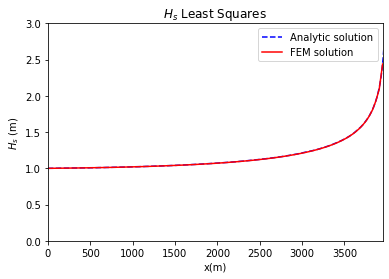

In [13]:
if test_case_no==4:
    Hs_vec=np.zeros(len(lat_coords))
    i=0
    #calc Hs at each point in physical space
    m_1D=IntervalMesh(30,0.25,2.0)
    V_1D=FunctionSpace(m_1D, "CG",1)
    i=0
    for lat in lat_coords:
        print(lat)

        test1=my1DExpression(u_final,x=lat)
        Uy=interpolate(test1,V_1D)
        intUy=4*np.sqrt(assemble(Uy*dx))
        Hs_vec[i]=intUy
        i=i+1
    
    #attempt to read in analytic
    fname='Shoaling_Analytic.txt'
    f=open(fname,"r")
    lines=f.readlines()
    f.close()
    column_names=lines[0].split()
    print(column_names)
    A=np.zeros((999,len(column_names))) #should be 1000, but last row is garbage
    ctr=0
    for line in lines[2:-1]:
        A[ctr,:]=line.split()
        ctr+=1

    #now plot
    plt.plot(A[:,0],A[:,1],'b--',label='Analytic solution')

    plt.plot(lat_coords[:],Hs_vec[:],'r',label='FEM solution')
    plt.title('$H_s$ Least Squares')
    plt.xlim((0,3950))
    plt.ylim((0,3))
    plt.xlabel('x(m)')
    plt.ylabel('$H_s$ (m)')
    plt.legend()
    #plt.savefig('CaseA21_LSQ.png')
    

In [11]:
if test_case_no==2:
    mesh = RectangleMesh(Point(0.0,0.0),Point(1.0,1.0),50,50)
    u_D = Expression('(-4*pow(x[1]-0.5,2)+1)*(x[0] + (exp(gamma*t*c_sigma*x[0]) -1 )/(1-exp(gamma*t*c_sigma)))',
                 degree=4, c_sigma=1,gamma=100,t=0.01,domain=mesh)

    p=plot(u_D,mesh=mesh)
    plt.colorbar(p)